In [7]:
import os
import pandas as pd
from config import gkey
import requests
import matplotlib.pyplot as plt
import json


In [8]:
# import csv, save csv to df, and delete necessary column
file_path2 = os.path.join("nba-players-stats", "Players.csv")
stats_df2 = pd.read_csv(file_path2)
del stats_df2['Unnamed: 0']
stats_df2


,Player,height,weight,collage,born,birth_city,birth_state
0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky
...,...,...,...,...,...,...,...
3917,Troy Williams,198.0,97.0,South Carolina State University,1969.0,Columbia,South Carolina
3918,Kyle Wiltjer,208.0,108.0,Gonzaga University,1992.0,Portland,Oregon
3919,Stephen Zimmerman,213.0,108.0,"University of Nevada, Las Vegas",1996.0,Hendersonville,Tennessee
3920,Paul Zipser,203.0,97.0,NaN,1994.0,Heidelberg,Germany


In [9]:
# extract only the columns we need
home_df = stats_df2[["Player", "birth_city", "birth_state"]]
# delete any rows that have NaN because I can't work with and map the location if there isn't a location listed
home_df = home_df.dropna(how='any')
home_df


,Player,birth_city,birth_state
1,Cliff Barker,Yorktown,Indiana
4,Ralph Beard,Hardinsburg,Kentucky
6,Charlie Black,Arco,Idaho
7,Nelson Bobb,Philadelphia,Pennsylvania
8,Jake Bornheimer,New Brunswick,New Jersey
...,...,...,...
3917,Troy Williams,Columbia,South Carolina
3918,Kyle Wiltjer,Portland,Oregon
3919,Stephen Zimmerman,Hendersonville,Tennessee
3920,Paul Zipser,Heidelberg,Germany


In [10]:
# check to see how many players were born each location
state_counts = home_df["birth_state"].value_counts()
state_counts
# convert the series above to df
state_counts_df = state_counts.to_frame()
# reset index so birth state is its own column
state_counts_df = state_counts_df.reset_index()
# rename columns
state_counts_df = state_counts_df.rename(columns={"index":"State/Country", "birth_state":"Number of Players Born in State/Country"})
# only take the top 50 locations so the bar graph isn't excessive
top_50 = state_counts_df.iloc[0:50, :]
top_50


,State/Country,Number of Players Born in State/Country
0,California,344
1,New York,290
2,Illinois,209
3,Pennsylvania,163
4,Ohio,137
5,Michigan,131
6,Texas,129
7,Georgia,118
8,Louisiana,101
9,Florida,96


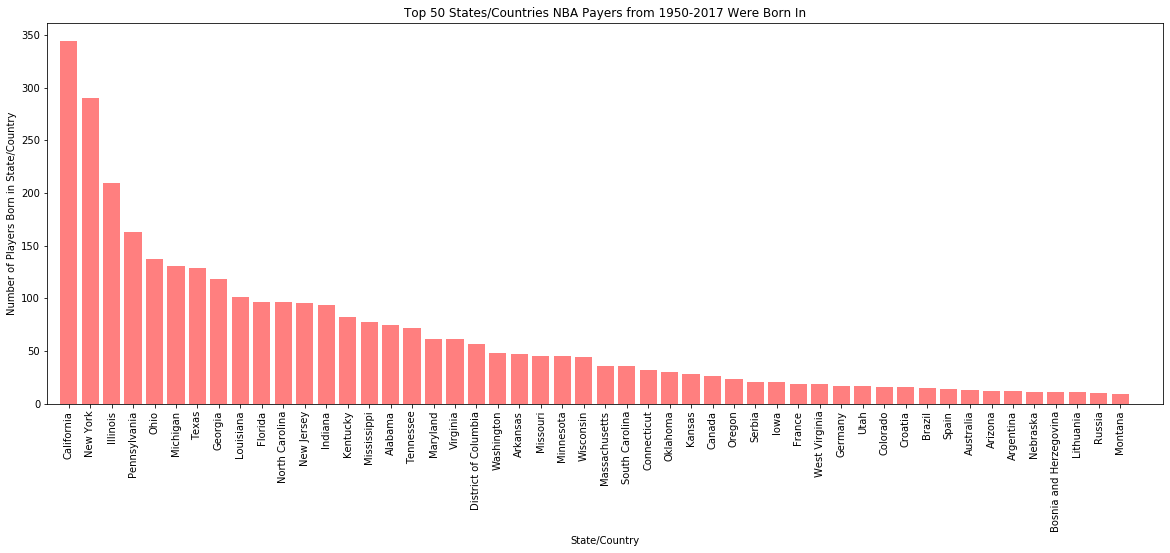

In [12]:
# creates bar graph of top 50 birth locations of NBA players since 1950
x = top_50["State/Country"]
y = top_50["Number of Players Born in State/Country"]
plt.figure(figsize=(20,7))
plt.bar(x, y, color='r', alpha=0.5, align="center")
plt.xticks(rotation=90)
plt.xlim(-1, len(x)+1)
plt.xlabel("State/Country")
plt.ylabel("Number of Players Born in State/Country")
plt.title("Top 50 States/Countries NBA Payers from 1950-2017 Were Born In")
plt.savefig("Figures/birth loc graph since 1950.png")


In [21]:
# adds new empty columns to df
home_df['lat'] = ""
home_df['lng'] = ""
home_df


,Player,birth_city,birth_state,lat,lng
1,Cliff Barker,Yorktown,Indiana,,
4,Ralph Beard,Hardinsburg,Kentucky,,
6,Charlie Black,Arco,Idaho,,
7,Nelson Bobb,Philadelphia,Pennsylvania,,
8,Jake Bornheimer,New Brunswick,New Jersey,,
...,...,...,...,...,...
3917,Troy Williams,Columbia,South Carolina,,
3918,Kyle Wiltjer,Portland,Oregon,,
3919,Stephen Zimmerman,Hendersonville,Tennessee,,
3920,Paul Zipser,Heidelberg,Germany,,


In [47]:
# itterate through every index and row of df
for index, row in home_df.iterrows():
# sets target place to the name of each player's birth location
    target_place = "{0},{1},{2}".format(row['birth_city'], row['birth_state'], "US")
# sets parameters for url
    params = {
        "address": target_place,
        "key": gkey
    }
# if geocode can find the coordinates for the college, proceed, if not, output a print statement
    try:
        base_url = "https://maps.googleapis.com/maps/api/geocode/json"
# extracts contents of API
        response = requests.get(base_url, params = params).json()
# sets variable to the path to take within the API dictionary
        results = response['results'][0]["geometry"]["location"]
# adds the lat and lng of each location to the df
        home_df.loc[index, 'lat'] = results["lat"]
        home_df.loc[index, 'lng'] = results["lng"]
    except IndexError:
        print("Can't find coordinates of town... skipping")
    

Can't find coordinates of town... skipping
Can't find coordinates of town... skipping
Can't find coordinates of town... skipping
Can't find coordinates of town... skipping


In [48]:
home_df


,Player,birth_city,birth_state,lat,lng
1,Cliff Barker,Yorktown,Indiana,40.1737,-85.4941
4,Ralph Beard,Hardinsburg,Kentucky,37.7801,-86.4605
6,Charlie Black,Arco,Idaho,43.6366,-113.3
7,Nelson Bobb,Philadelphia,Pennsylvania,39.9526,-75.1652
8,Jake Bornheimer,New Brunswick,New Jersey,40.4862,-74.4518
...,...,...,...,...,...
3917,Troy Williams,Columbia,South Carolina,34.0007,-81.0348
3918,Kyle Wiltjer,Portland,Oregon,45.5051,-122.675
3919,Stephen Zimmerman,Hendersonville,Tennessee,36.3048,-86.62
3920,Paul Zipser,Heidelberg,Germany,49.3988,8.67243


In [55]:
# saves df to csv
output_data_file = "Output csv's/hometowns.csv"
home_df.to_csv(output_data_file)


In [13]:
# saves csv to df so I don't have to run above cells every time
file_path3 = os.path.join("Output csv's", "hometowns.csv")
homecsv_df = pd.read_csv(file_path3)
homecsv_df


,Unnamed: 0,Player,birth_city,birth_state,lat,lng
0,1,Cliff Barker,Yorktown,Indiana,40.173655,-85.494140
1,4,Ralph Beard,Hardinsburg,Kentucky,37.780059,-86.460534
2,6,Charlie Black,Arco,Idaho,43.636569,-113.300284
3,7,Nelson Bobb,Philadelphia,Pennsylvania,39.952584,-75.165222
4,8,Jake Bornheimer,New Brunswick,New Jersey,40.486216,-74.451819
...,...,...,...,...,...,...
3434,3917,Troy Williams,Columbia,South Carolina,34.000710,-81.034814
3435,3918,Kyle Wiltjer,Portland,Oregon,45.505106,-122.675026
3436,3919,Stephen Zimmerman,Hendersonville,Tennessee,36.304773,-86.619996
3437,3920,Paul Zipser,Heidelberg,Germany,49.398752,8.672434


In [14]:
# delete unnecessary column
del homecsv_df['Unnamed: 0']
homecsv_df


,Player,birth_city,birth_state,lat,lng
0,Cliff Barker,Yorktown,Indiana,40.173655,-85.494140
1,Ralph Beard,Hardinsburg,Kentucky,37.780059,-86.460534
2,Charlie Black,Arco,Idaho,43.636569,-113.300284
3,Nelson Bobb,Philadelphia,Pennsylvania,39.952584,-75.165222
4,Jake Bornheimer,New Brunswick,New Jersey,40.486216,-74.451819
...,...,...,...,...,...
3434,Troy Williams,Columbia,South Carolina,34.000710,-81.034814
3435,Kyle Wiltjer,Portland,Oregon,45.505106,-122.675026
3436,Stephen Zimmerman,Hendersonville,Tennessee,36.304773,-86.619996
3437,Paul Zipser,Heidelberg,Germany,49.398752,8.672434


In [15]:
# drop any rows with NaN because geocode couldn't find those lat and lng- can't map those
homecsv_df = homecsv_df.dropna(how='any')
homecsv_df


,Player,birth_city,birth_state,lat,lng
0,Cliff Barker,Yorktown,Indiana,40.173655,-85.494140
1,Ralph Beard,Hardinsburg,Kentucky,37.780059,-86.460534
2,Charlie Black,Arco,Idaho,43.636569,-113.300284
3,Nelson Bobb,Philadelphia,Pennsylvania,39.952584,-75.165222
4,Jake Bornheimer,New Brunswick,New Jersey,40.486216,-74.451819
...,...,...,...,...,...
3434,Troy Williams,Columbia,South Carolina,34.000710,-81.034814
3435,Kyle Wiltjer,Portland,Oregon,45.505106,-122.675026
3436,Stephen Zimmerman,Hendersonville,Tennessee,36.304773,-86.619996
3437,Paul Zipser,Heidelberg,Germany,49.398752,8.672434


In [16]:
#dependency
import gmaps

# Access maps with unique API key
gmaps.configure(api_key=gkey)

# creates heat map of birth locations of NBA players since 1950
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(homecsv_df[["lat", "lng"]])
fig.add_layer(heatmap_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [17]:
# imports another csv and saves it as df
file_path3 = os.path.join("nba-players-stats", "Seasons_Stats.csv")
stats_df3 = pd.read_csv(file_path3)
# deletes unnecessary column
del stats_df3['Unnamed: 0']
# exrtacts only data from 2017- the most current available
stats2017 = stats_df3.loc[stats_df3["Year"] == 2017.0]
stats2017


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24096,2017.0,Alex Abrines,SG,23.0,OKC,68.0,6.0,1055.0,10.1,0.560,...,0.898,18.0,68.0,86.0,40.0,37.0,8.0,33.0,114.0,406.0
24097,2017.0,Quincy Acy,PF,26.0,TOT,38.0,1.0,558.0,11.8,0.565,...,0.750,20.0,95.0,115.0,18.0,14.0,15.0,21.0,67.0,222.0
24098,2017.0,Quincy Acy,PF,26.0,DAL,6.0,0.0,48.0,-1.4,0.355,...,0.667,2.0,6.0,8.0,0.0,0.0,0.0,2.0,9.0,13.0
24099,2017.0,Quincy Acy,PF,26.0,BRK,32.0,1.0,510.0,13.1,0.587,...,0.754,18.0,89.0,107.0,18.0,14.0,15.0,19.0,58.0,209.0
24100,2017.0,Steven Adams,C,23.0,OKC,80.0,80.0,2389.0,16.5,0.589,...,0.611,282.0,333.0,615.0,86.0,88.0,78.0,146.0,195.0,905.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


In [18]:
# delete rows where team = total because those are present when a player has more than 1 entry due to being on more than 1 team
cleaned2017_df = stats2017.loc[stats2017["Tm"] != "TOT"]
cleaned2017_df


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24096,2017.0,Alex Abrines,SG,23.0,OKC,68.0,6.0,1055.0,10.1,0.560,...,0.898,18.0,68.0,86.0,40.0,37.0,8.0,33.0,114.0,406.0
24098,2017.0,Quincy Acy,PF,26.0,DAL,6.0,0.0,48.0,-1.4,0.355,...,0.667,2.0,6.0,8.0,0.0,0.0,0.0,2.0,9.0,13.0
24099,2017.0,Quincy Acy,PF,26.0,BRK,32.0,1.0,510.0,13.1,0.587,...,0.754,18.0,89.0,107.0,18.0,14.0,15.0,19.0,58.0,209.0
24100,2017.0,Steven Adams,C,23.0,OKC,80.0,80.0,2389.0,16.5,0.589,...,0.611,282.0,333.0,615.0,86.0,88.0,78.0,146.0,195.0,905.0
24101,2017.0,Arron Afflalo,SG,31.0,SAC,61.0,45.0,1580.0,9.0,0.559,...,0.892,9.0,116.0,125.0,78.0,21.0,7.0,42.0,104.0,515.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,...,0.679,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0
24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,...,0.564,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0
24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,...,0.600,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0
24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,...,0.775,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0


In [19]:
# finds the sum of each column for each player
player_grouped = cleaned2017_df.groupby(["Player"]).sum()
player_grouped


,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Hammons,2017.0,24.0,22.0,0.0,163.0,8.4,0.472,0.238,0.476,5.4,...,0.450,8.0,28.0,36.0,4.0,1.0,13.0,10.0,21.0,48.0
Aaron Brooks,2017.0,32.0,65.0,0.0,894.0,9.5,0.507,0.427,0.133,2.3,...,0.800,18.0,51.0,69.0,125.0,25.0,9.0,66.0,93.0,322.0
Aaron Gordon,2017.0,21.0,80.0,72.0,2298.0,14.4,0.530,0.309,0.251,5.3,...,0.719,116.0,289.0,405.0,150.0,64.0,40.0,89.0,172.0,1019.0
Aaron Harrison,2017.0,22.0,5.0,0.0,17.0,-2.2,0.102,0.500,0.500,0.0,...,0.500,0.0,3.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0
Adreian Payne,2017.0,25.0,18.0,0.0,135.0,14.4,0.505,0.278,0.352,7.7,...,0.737,9.0,24.0,33.0,7.0,8.0,7.0,8.0,32.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wilson Chandler,2017.0,29.0,71.0,33.0,2197.0,14.9,0.545,0.347,0.207,5.2,...,0.727,103.0,356.0,459.0,141.0,52.0,30.0,114.0,172.0,1117.0
Yogi Ferrell,4034.0,46.0,46.0,29.0,1197.0,20.6,1.023,0.983,0.539,4.5,...,1.502,20.0,91.0,111.0,172.0,42.0,9.0,70.0,90.0,462.0
Zach LaVine,2017.0,21.0,47.0,47.0,1749.0,14.6,0.576,0.437,0.197,1.2,...,0.836,18.0,141.0,159.0,139.0,41.0,10.0,85.0,104.0,889.0


In [20]:
# extracts only the column "vorp", which is a good indicator of player ability
player_grouped["VORP"]


Player
A.J. Hammons      -0.1
Aaron Brooks      -0.6
Aaron Gordon       0.8
Aaron Harrison     0.0
Adreian Payne      0.0
                  ... 
Wilson Chandler    0.7
Yogi Ferrell       0.4
Zach LaVine        0.8
Zach Randolph      0.0
Zaza Pachulia      1.5
Name: VORP, Length: 486, dtype: float64

In [21]:
# convery vorp series into df
vorp_df = player_grouped["VORP"].to_frame()
# sorts values by vorp, from largest to smallest
vorp_sorted_df = vorp_df.sort_values("VORP", ascending = False)
vorp_sorted_df


,VORP
Player,
Russell Westbrook,12.4
James Harden,9.0
LeBron James,7.3
Giannis Antetokounmpo,6.9
Jimmy Butler,6.3
...,...
Brandon Ingram,-1.1
Isaiah Whitehead,-1.2
Malcolm Delaney,-1.2


In [22]:
# saves vorp df to csv
output_data_file = "Output csv's/vorp_sorted.csv"
vorp_sorted_df.to_csv(output_data_file)


In [23]:
# extracts only the top 212 vorp players
# chose 212 because some data gets lost when we merge df's in next cell
top_vorp_df = vorp_sorted_df.iloc[0:212, :]
# resets index so player is its own column
top_vorp_df = top_vorp_df.reset_index()
top_vorp_df


,Player,VORP
0,Russell Westbrook,12.4
1,James Harden,9.0
2,LeBron James,7.3
3,Giannis Antetokounmpo,6.9
4,Jimmy Butler,6.3
...,...,...
207,Enes Kanter,0.3
208,Darrell Arthur,0.3
209,Boban Marjanovic,0.2
210,Dirk Nowitzki,0.2


In [24]:
# merges vorp df with hometown df
merge_df = pd.merge(top_vorp_df, homecsv_df, on="Player")
merge_df


,Player,VORP,birth_city,birth_state,lat,lng
0,Russell Westbrook,12.4,Long Beach,California,33.770050,-118.193740
1,James Harden,9.0,Los Angeles,California,34.052234,-118.243685
2,LeBron James,7.3,Akron,Ohio,41.081445,-81.519005
3,Giannis Antetokounmpo,6.9,Athens,Greece,37.982067,23.755333
4,Jimmy Butler,6.3,Houston,Texas,29.760427,-95.369803
...,...,...,...,...,...,...
195,Enes Kanter,0.3,Zurich,Switzerland,47.359005,8.551776
196,Darrell Arthur,0.3,Dallas,Texas,32.776664,-96.796988
197,Boban Marjanovic,0.2,Zajecar,Serbia,43.901505,22.273801
198,Dirk Nowitzki,0.2,Wurzburg,Germany,49.791304,9.953355


In [25]:
# check to see how many players were born each location
state_counts2 = merge_df["birth_state"].value_counts()
state_counts2
# convert series to df
state_counts_df2 = state_counts2.to_frame()
# reset index so birth city is its own column
state_counts_df2 = state_counts_df2.reset_index()
state_counts_df2
# rename columns
state_counts_df2 = state_counts_df2.rename(columns={"index":"State/Country", "birth_state":"Number of Players Born in State/Country"})
# take only the top 50 so bar graph isn't excessive
top_50_2 = state_counts_df2.iloc[0:50, :]
top_50_2


,State/Country,Number of Players Born in State/Country
0,California,35
1,Illinois,10
2,Indiana,9
3,Louisiana,9
4,Georgia,8
5,North Carolina,8
6,New York,8
7,Texas,7
8,Pennsylvania,6
9,Maryland,5


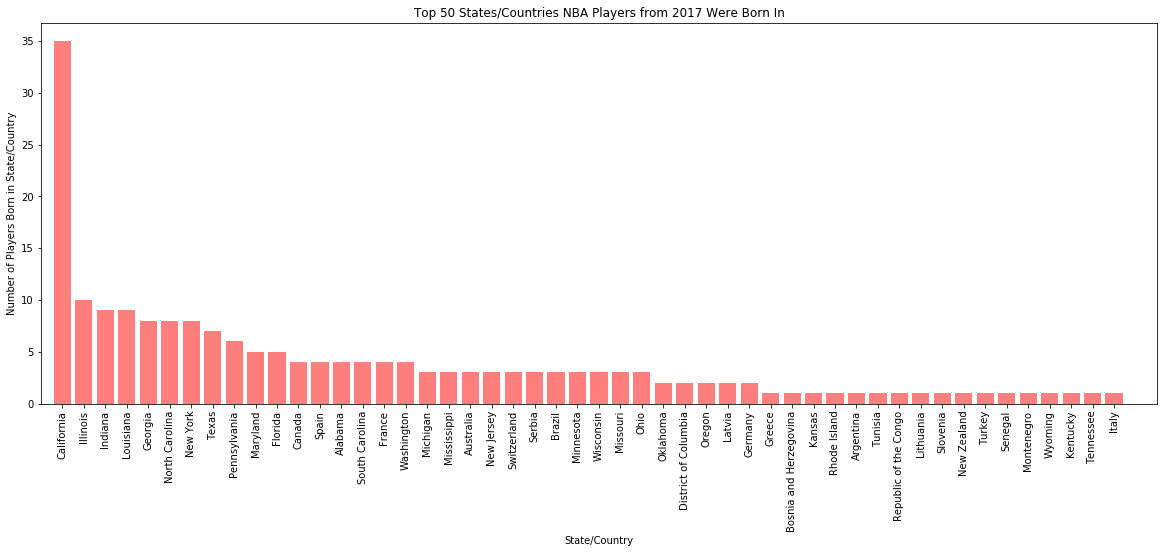

In [26]:
# creates bar graph of top 50 birth locations of 2017 NBA players
x = top_50_2["State/Country"]
y = top_50_2["Number of Players Born in State/Country"]
plt.figure(figsize=(20,7))
plt.bar(x, y, color='r', alpha=0.5, align="center")
plt.xticks(rotation=90)
plt.xlim(-1, len(x)+1)
plt.xlabel("State/Country")
plt.ylabel("Number of Players Born in State/Country")
plt.title("Top 50 States/Countries NBA Players from 2017 Were Born In")
plt.savefig("Figures/birth loc bar graph 2017.png")


In [16]:
#dependency
import gmaps

# Access maps with unique API key
gmaps.configure(api_key=gkey)

# creates heat map of birth locations of 2017 NBA players
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(merge_df[["lat", "lng"]])
fig.add_layer(heatmap_layer)
fig


Figure(layout=FigureLayout(height='420px'))